<a href="https://colab.research.google.com/github/Nevermetyou65/GANs-Exercises/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)
z_dim = 100 # length

In [ ]:
def build_generator(z_dim):
    
    model = Sequential()
    model.add(layers.Dense(units=256*7*7, input_shape=(z_dim,)))
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(layers.Activation('tanh'))

    return model

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()
    #1
    model.add(layers.Conv2D(32, kernel_size=3, 
                            strides=2, input_shape=img_shape, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    #2
    model.add(layers.Conv2D(64, kernel_size=3,
                            strides=2, padding='same'))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    #3
    model.add(layers.Conv2D(128, kernel_size=3,
                            strides=2, padding='same'))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    # -------
    model.add(layers.Flatten())
    model.add(layers.Dense(units=1, activation='sigmoid'))

    return model

In [ ]:
def build_dcgan(generator, discriminator):
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              0

In [ ]:
generator = build_generator(z_dim)
discriminator.trainable = False

dcgan = build_dcgan(generator, discriminator)
dcgan.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    (X_train, _), (_, _) = keras.datasets.mnist.load_data()
    X_train = (X_train / 127.5) - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):

        idx = np.random.randint(0, X_train.shape[0], size=batch_size) # สุ่ม index มาหลายๆอันเลย
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z) # create fake image

        # train discriminator as sapeate compiled model
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # total loss
        d_loss, accuracy = 0.5 *  np.add(d_loss_real, d_loss_fake)

        # train generator through whole gan
        z = np.random.normal(0, 1, (batch_size, 100))
        # gen_imgs = generator.predict(z)
        g_loss = dcgan.train_on_batch(z, real)
        
        if  (iteration  + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            sample_images(generator) # input trained generator in that interation for image generation
            print('='*50)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_cols=4):

    z = np.random.normal(0, 1, (image_grid_rows*image_grid_cols, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5 #  เพราะว่า generator layer สุดท้ายเป็น tanh ->> -1,1
    fig, ax = plt.subplots(image_grid_rows, image_grid_cols,
                           figsize=(4, 4),
                           sharey=True,
                           sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            ax[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            ax[i, j].axis('off')
            cnt += 1

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.713748, acc.: 30.47%] [G loss: 0.735999]
2000 [D loss: 0.698688, acc.: 43.36%] [G loss: 0.713008]
3000 [D loss: 0.696637, acc.: 38.67%] [G loss: 0.707376]
4000 [D loss: 0.697530, acc.: 34.77%] [G loss: 0.702973]
5000 [D loss: 0.693682, acc.: 47.66%] [G loss: 0.702122]
6000 [D loss: 0.692612, acc.: 52.73%] [G loss: 0.699941]
7000 [D loss: 0.689475, acc.: 58.98%] [G loss: 0.709409]
8000 [D loss: 0.685875, acc.: 58.20%] [G loss: 0.702887]
9000 [D loss: 0.685269, acc.: 60.16%] [G loss: 0.721361]
10000 [D loss: 0.680984, acc.: 57.42%] [G loss: 0.734238]
11000 [D loss: 0.672442, acc.: 67.58%] [G loss: 0.745141]
12000 [D loss: 0.672149, acc.: 62.50%] [G loss: 0.763649]
13000 [D loss: 0.669719, acc.: 60.16%] [G loss: 0.752780]
14000 [D loss: 0.647968, acc.: 68.36%] [G loss: 0.773306]
15000 [D loss: 0.650233, acc.: 66.80%] [G loss: 0.858434]
16000 [D loss: 0.646614, acc.: 64.06%] [G loss: 0.823516]
17000 [D loss: 0

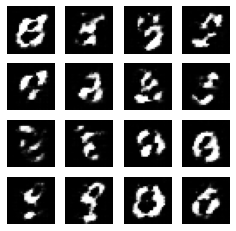

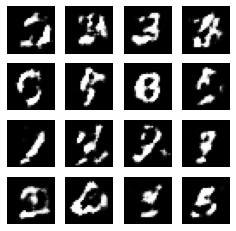

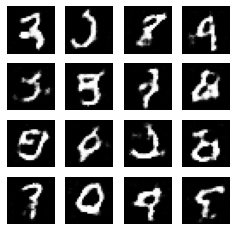

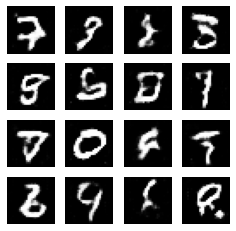

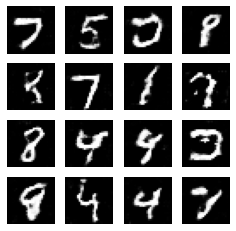

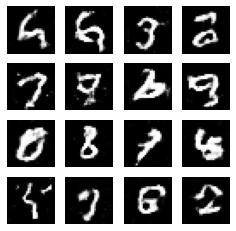

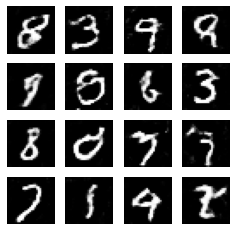

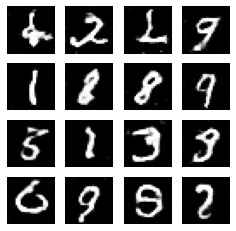

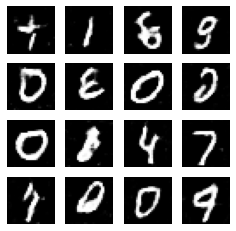

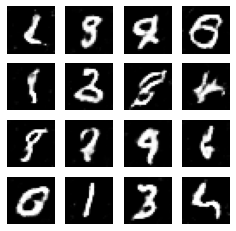

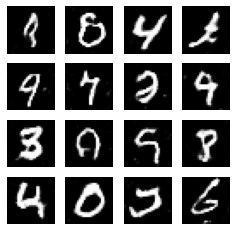

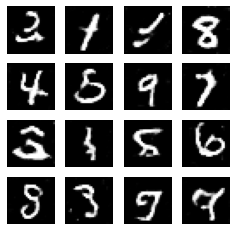

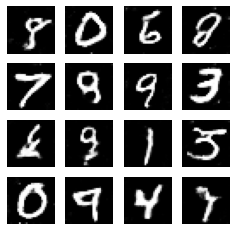

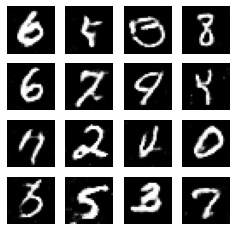

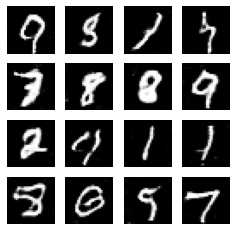

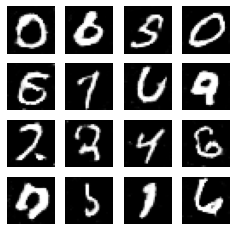

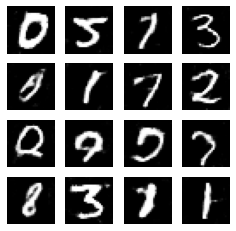

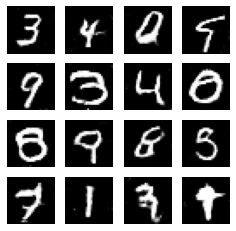

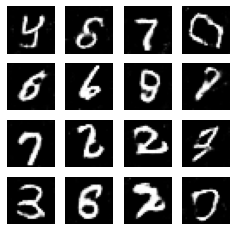

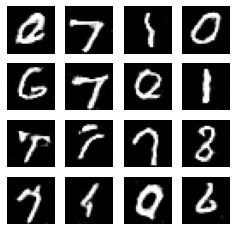

In [ ]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)